# Customer Churn Analysis

# EDA and Prediction

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.ticker as mtick 
import matplotlib.pyplot as plt
import os
sns.set(style = 'white')

**Let us read the data file in the python notebook**

In [2]:
telecom_cust = pd.read_csv('https://raw.githubusercontent.com/dsrscientist/DSData/master/Telecom_customer_churn.csv')

In [3]:
telecom_cust.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
telecom_cust.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

**Let's explore the data to see if there are any missing values.**

In [5]:
# Checking the data types of all the columns
telecom_cust.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [6]:
# Converting Total Charges to a numerical data type.
telecom_cust.TotalCharges = pd.to_numeric(telecom_cust.TotalCharges, errors='coerce')
telecom_cust.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

After looking at the above output, we can say that there are 11 missing values for Total Charges. Let us remove these 11 rows from our data set

In [7]:
#Removing missing values 
telecom_cust.dropna(inplace = True)
#Remove customer IDs from the data set
df2 = telecom_cust.iloc[:,1:]
#Converting the predictor variable in a binary numeric variable
df2['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df2['Churn'].replace(to_replace='No',  value=0, inplace=True)

#Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df2)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


# Correlation

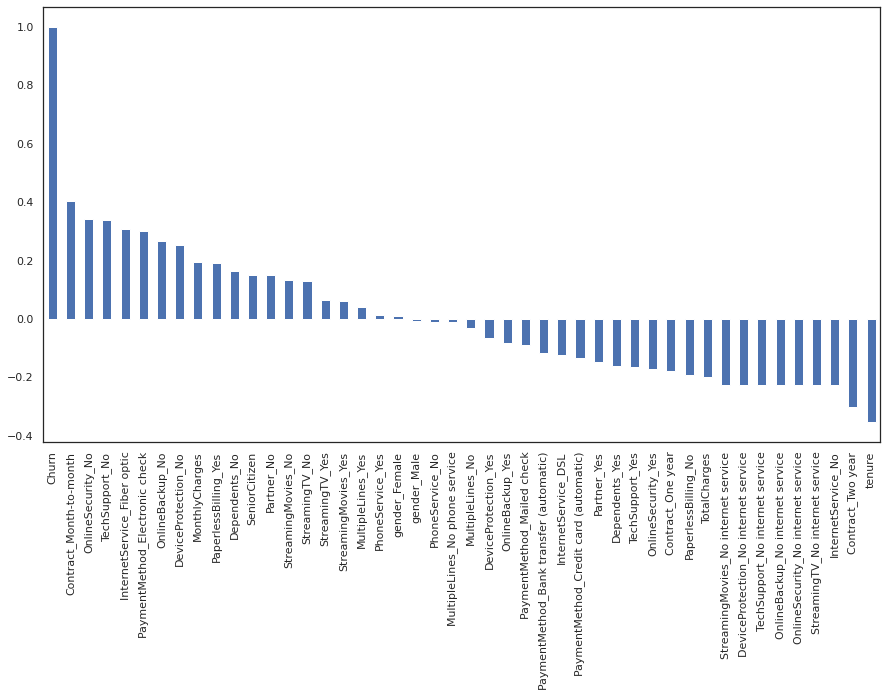

In [8]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(15,8))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

Month to month contracts, absence of online security and tech support seem to be positively correlated with churn. While, tenure, two year contracts seem to be negatively correlated with churn. 

Interestingly, services such as Online security, streaming TV, online backup, tech support, etc. without internet connection seem to be negatively related to churn.

We will explore the patterns for the above correlations below before we delve into modelling and identifying the important variables.

## Data Exploration

Let us first start with exploring our data set, to better understand the patterns in the data and potentially form some hypothesis. First we will look at the distribution of individual variables and then slice and dice our data for any interesting trends.

**A.)** ***Demographics*** - Let us first understand the gender, age range, patner and dependent status of the customers

1. **Gender Distribution** - About half of the customers in our data set are male while the other half are female

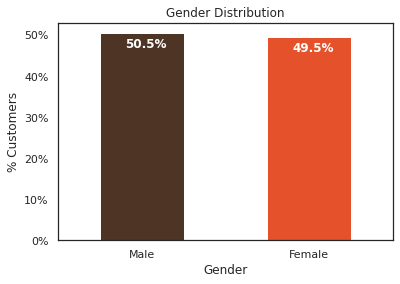

In [9]:
colors = ['#4D3425','#E4512B']
ax = (telecom_cust['gender'].value_counts()*100.0 /len(telecom_cust)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers')
ax.set_xlabel('Gender')
ax.set_ylabel('% Customers')
ax.set_title('Gender Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-3.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold')

2. **% Senior Citizens** - There are only 16% of the customers who are senior citizens. Thus most of our customers in the data are younger people.


Text(0.5, 1.0, '% of Senior Citizens')

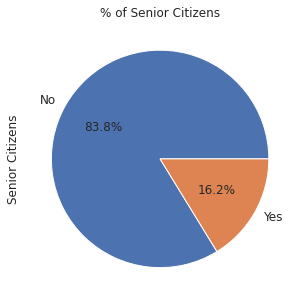

In [10]:
ax = (telecom_cust['SeniorCitizen'].value_counts()*100.0 /len(telecom_cust))\
.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)

3. **Partner and dependent status**  - About 50% of the customers have a partner, while only 30% of the total customers have dependents. 

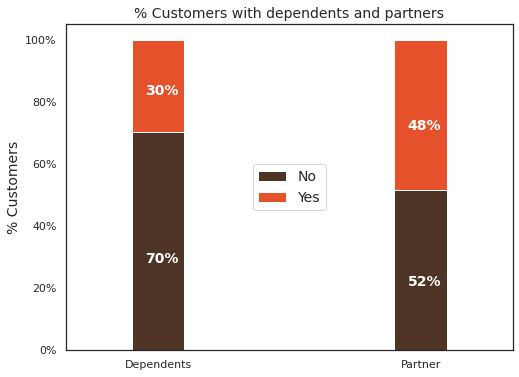

In [11]:
df2 = pd.melt(telecom_cust, id_vars=['customerID'], value_vars=['Dependents','Partner'])
df3 = df2.groupby(['variable','value']).count().unstack()
df3 = df3*100/len(telecom_cust)
colors = ['#4D3425','#E4512B']
ax = df3.loc[:,'customerID'].plot.bar(stacked=True, color=colors,
                                      figsize=(8,6),rot = 0,
                                     width = 0.2)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('')
ax.set_title('% Customers with dependents and partners',size = 14)
ax.legend(loc = 'center',prop={'size':14})

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

**What would be interesting is to look at the % of customers, who have partners, also have dependents. We will explore this next. **

Interestingly,  among the customers who have a partner, only about half of them also have a dependent, while other half do not have any independents. 
Additionally, as expected, among the customers who do not have any partner, a majority (80%) of them do not have any dependents .

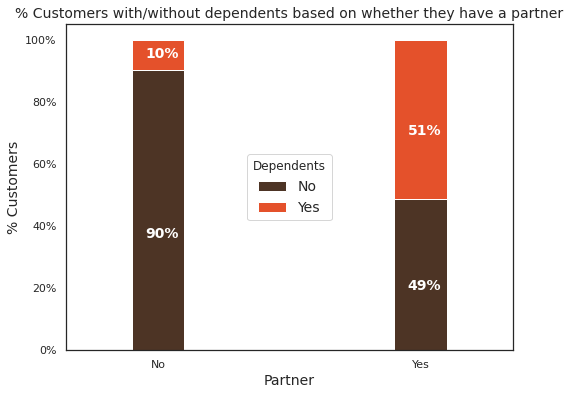

In [12]:
colors = ['#4D3425','#E4512B']
partner_dependents = telecom_cust.groupby(['Partner','Dependents']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Dependents',fontsize =14)
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers with/without dependents based on whether they have a partner',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

I also looked at any differences between the % of customers with/without dependents and partners by gender. There is no difference in their distribution by gender. Additionally, there is no difference in senior citizen status by gender.

### B.) **Customer Account Information**:  Let us now look at the tenure, contract

**1. Tenure:**  After looking at the below histogram we can see that a lot of customers have been with the telecom company for just a month, while quite a many are there for about 72 months. This could be potentially because different customers have different contracts. Thus based on the contract they are into it could be more/less easier for the customers to stay/leave the telecom company.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '# of Customers by their tenure')

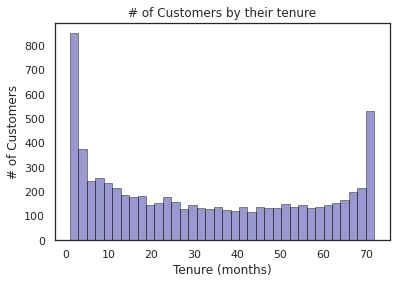

In [13]:
ax = sns.distplot(telecom_cust['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('# of Customers by their tenure')

**2. Contracts:** To understand the above graph, lets first look at the # of customers by different contracts. 

Text(0.5, 1.0, '# of Customers by Contract Type')

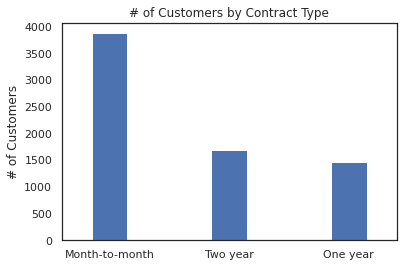

In [14]:
ax = telecom_cust['Contract'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('# of Customers')
ax.set_title('# of Customers by Contract Type')

As we can see from this graph most of the customers are in the month to month contract. While there are equal number of customers in the 1 year and 2 year contracts.



Below we will understand the tenure of customers based on their contract type.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Two Year Contract')

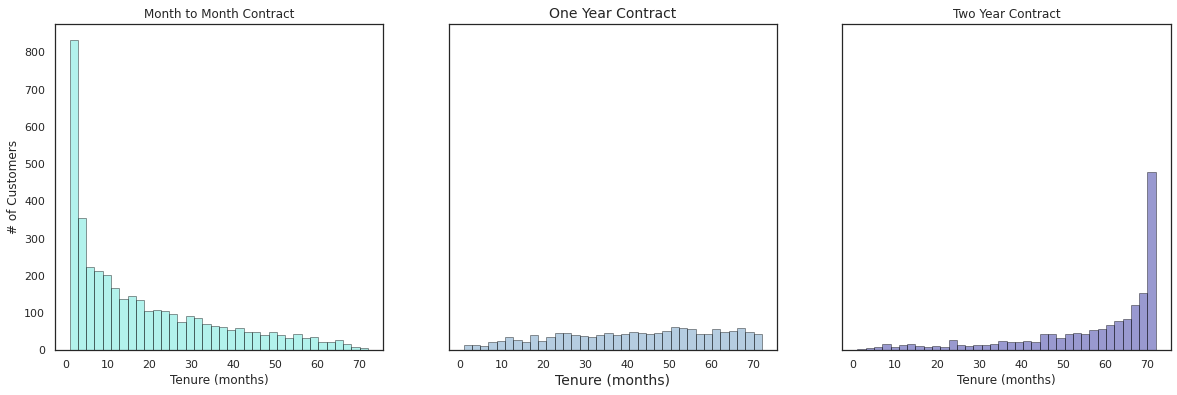

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.distplot(telecom_cust[telecom_cust['Contract']=='Month-to-month']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'turquoise',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Month to Month Contract')

ax = sns.distplot(telecom_cust[telecom_cust['Contract']=='One year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'steelblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_xlabel('Tenure (months)',size = 14)
ax.set_title('One Year Contract',size = 14)

ax = sns.distplot(telecom_cust[telecom_cust['Contract']=='Two year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'darkblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax3)

ax.set_xlabel('Tenure (months)')
ax.set_title('Two Year Contract')

Interestingly most of the monthly contracts last for 1-2 months, while the 2 year contracts tend to last for about 70 months. This shows that the customers taking a longer contract are more loyal to the company and tend to stay with it for a longer period of time. 

This is also what we saw in the earlier chart on correlation with the churn rate. 

###  C. Let us now look at the distribution of various services used by customers

In [16]:
telecom_cust.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

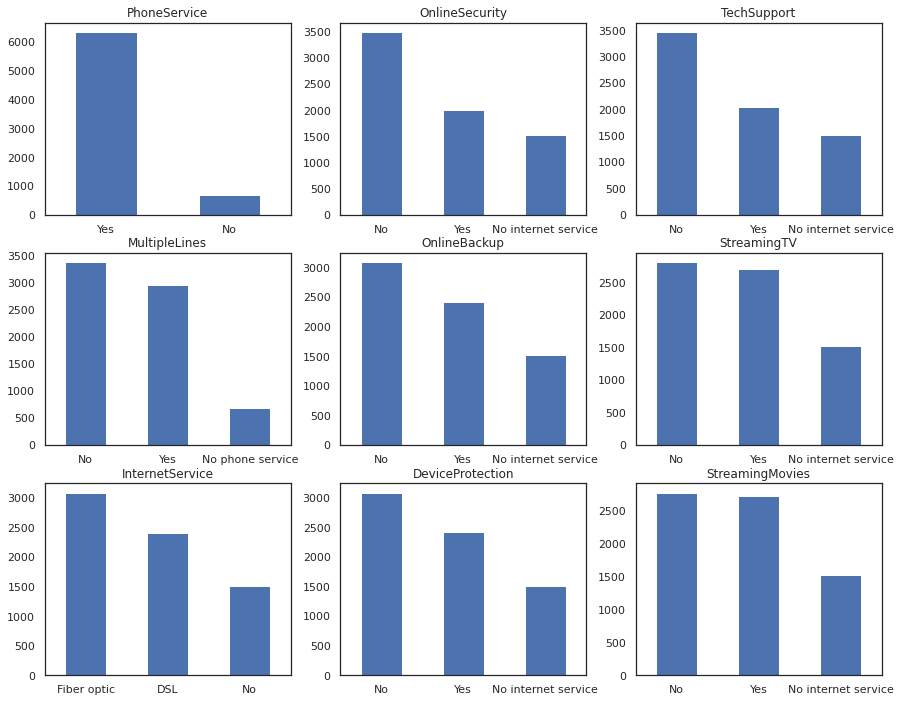

In [17]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services):
    if i < 3:
        ax = telecom_cust[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = telecom_cust[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = telecom_cust[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)

### D.) Now let's take a quick look at the relation between monthly and total charges

We will observe that the total charges increases as the monthly bill for a customer increases.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


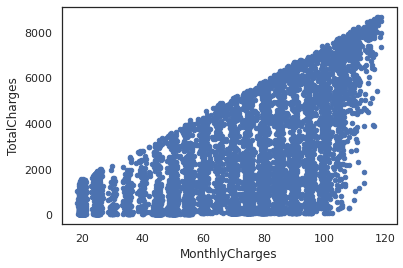

In [18]:
telecom_cust[['MonthlyCharges', 'TotalCharges']].plot.scatter(x = 'MonthlyCharges',
                                                              y='TotalCharges')

### E.) Finally, let's take a look at out predictor variable (Churn) and understand its interaction with other important variables as was found out in the correlation plot. 

1. Lets first look at the churn rate in our data

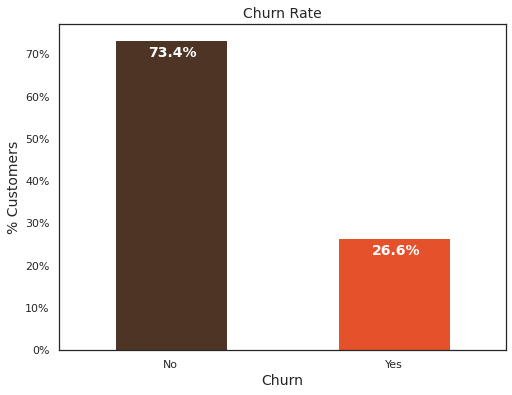

In [19]:
colors = ['#4D3425','#E4512B']
ax = (telecom_cust['Churn'].value_counts()*100.0 /len(telecom_cust)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors,
                                                                         figsize = (8,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('Churn',size = 14)
ax.set_title('Churn Rate', size = 14)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold',
           size = 14)

In our data, 74% of the customers do not churn. Clearly the data is skewed as we would expect a large majority of the customers to not churn. This is important to keep in mind for our modelling as skeweness could lead to a lot of false negatives. We will see in the modelling section on how to avoid skewness in the data.

2. Lets now explore the churn rate by tenure, seniority, contract type, monthly charges and total charges to see how it varies by these variables.

**i.) Churn vs Tenure**: As we can see form the below plot, the customers who do not churn, they tend to stay for a longer tenure with the telecom company. 

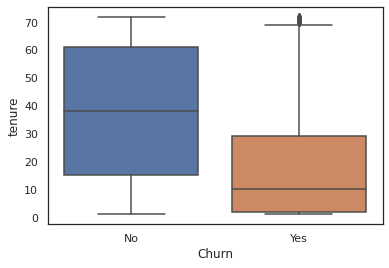

In [20]:
sns.boxplot(x = telecom_cust.Churn, y = telecom_cust.tenure)

**ii.) Churn by Contract Type**: Similar to what we saw in the correlation plot, the customers who have a month to month contract have a very high churn rate.

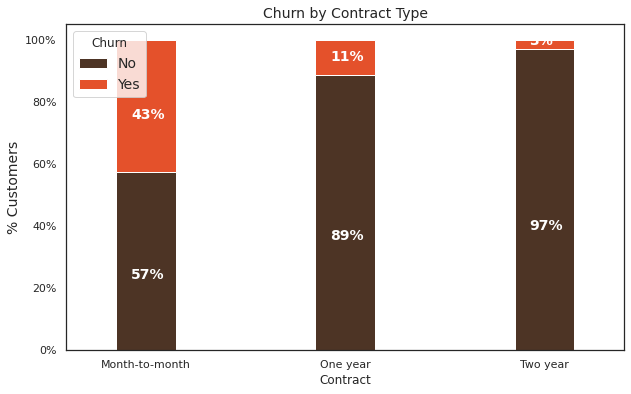

In [21]:
colors = ['#4D3425','#E4512B']
contract_churn = telecom_cust.groupby(['Contract','Churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Contract Type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

**iii.) Churn by Seniority**: Senior Citizens have almost double the churn rate than younger population.

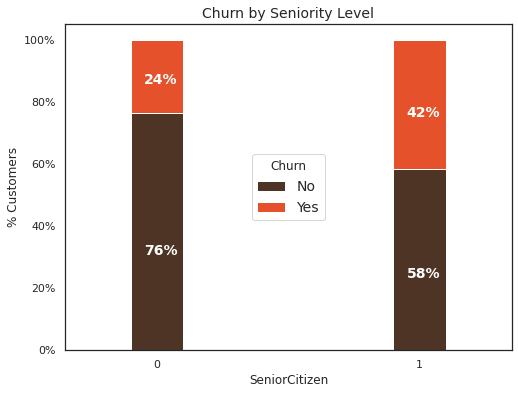

In [22]:
colors = ['#4D3425','#E4512B']
seniority_churn = telecom_cust.groupby(['SeniorCitizen','Churn']).size().unstack()

ax = (seniority_churn.T*100.0 / seniority_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers')
ax.set_title('Churn by Seniority Level',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',size =14)

**iv.) Churn by Monthly Charges**: Higher % of customers churn when the monthly charges are high.

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

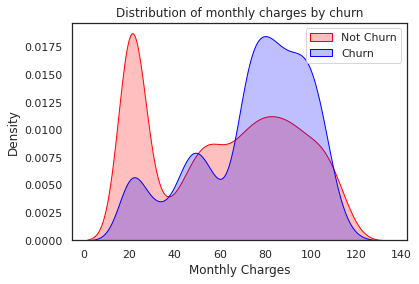

In [23]:
ax = sns.kdeplot(telecom_cust.MonthlyCharges[(telecom_cust["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_cust.MonthlyCharges[(telecom_cust["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

**v.) Churn by Total Charges**: It seems that there is higer churn when the total charges are lower.

Text(0.5, 1.0, 'Distribution of total charges by churn')

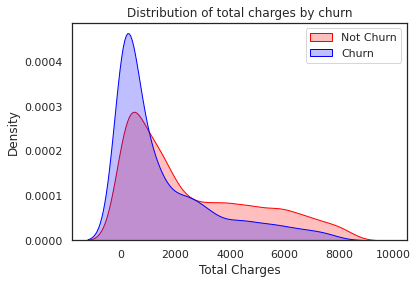

In [24]:
ax = sns.kdeplot(telecom_cust.TotalCharges[(telecom_cust["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_cust.TotalCharges[(telecom_cust["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges by churn')

## After going through the above EDA we will develop some predictive models and compare them.

We will develop Logistic Regression, Random Forest, SVM, ADA Boost and XG Boost

**1. Logistic Regression**

In [25]:
# We will use the data frame where we had created dummy variables
y = df_dummies['Churn'].values
X = df_dummies.drop(columns = ['Churn'])

# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

It is important to scale the variables in logistic regression so that all of them are within a range of 0 to 1. This helped me improve the accuracy from 79.7% to 80.7%. Further, you will notice below that the importance of variables is also aligned with what we are seeing in Random Forest algorithm and the EDA we conducted above.

In [26]:
# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [27]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)

In [28]:
from sklearn import metrics
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print (metrics.accuracy_score(y_test, prediction_test))

0.8075829383886256


AxesSubplot(0.125,0.125;0.775x0.755)


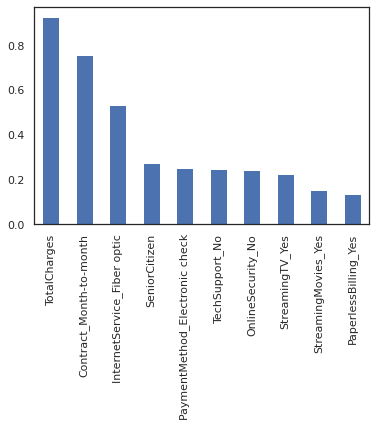

In [29]:
# To get the weights of all the variables
weights = pd.Series(model.coef_[0],
                 index=X.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))


AxesSubplot(0.125,0.125;0.775x0.755)


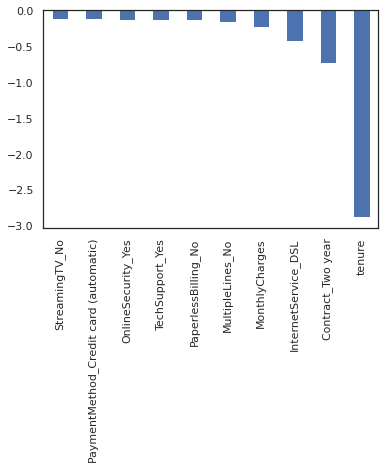

In [30]:
print(weights.sort_values(ascending = False)[-10:].plot(kind='bar'))

**Observations**

We can see that some variables have a negative relation to our predicted variable (Churn), while some have positive relation. Negative relation means that likeliness of churn decreases with that variable. Let us summarize some of the interesting features below:
* As we saw in our EDA, having a 2 month contract reduces chances of churn. 2 month contract along with tenure have the most negative relation with Churn as predicted by logistic regressions
* Having DSL internet service also reduces the proability of Churn
* Lastly, total charges, monthly contracts, fibre optic internet services and seniority can lead to higher churn rates. This is interesting because although fibre optic services are faster, customers are  likely to churn because of it. I think we need to explore more to better understad why this is happening. 

Any hypothesis on the above would be really helpful! 

**2. Random Forest**

In [31]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


0.8088130774697939


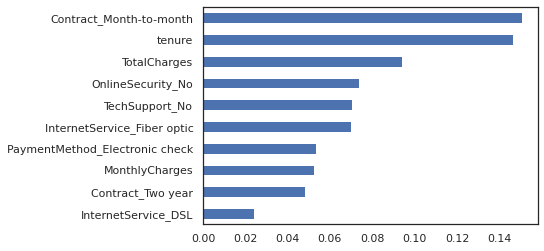

In [32]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

**Observations:**

* From random forest algorithm, monthly contract, tenure and total charges are the most important predictor variables to predict churn.
* The results from random forest are very similar to that of the logistic regression and in line to what we had expected from our EDA

**3. Support Vecor Machine (SVM)**

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [34]:
from sklearn.svm import SVC

model.svm = SVC(kernel='linear') 
model.svm.fit(X_train,y_train)
preds = model.svm.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.820184790334044

In [35]:
# Create the Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,preds))  

[[953  89]
 [164 201]]


Wth SVM I was able to increase the accuracy to upto 82%. However, we need to take a deeper look at the true positive and true negative rates, including the Area Under the Curve (AUC) for a better prediction. I will explore this soon. Stay Tuned!

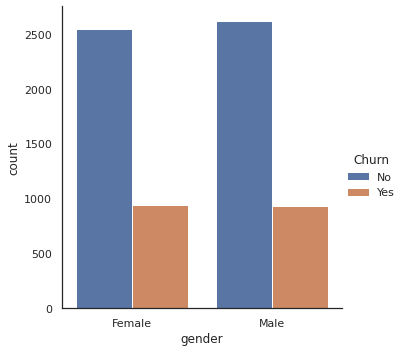

In [36]:
ax1 = sns.catplot(x="gender", kind="count", hue="Churn", data=telecom_cust,
                  estimator=lambda x: sum(x==0)*100.0/len(x))
#ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

**4. ADA Boost**

In [37]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
# n_estimators = 50 (default value) 
# base_estimator = DecisionTreeClassifier (default value)
model.fit(X_train,y_train)
preds = model.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.8159203980099502

**5. XG Boost**

In [38]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.8294243070362474

Interestingly with XG Boost I was able to increase the accuracy on test data to almost 83%. Clearly, XG Boost is a winner among all other techniques. XG Boost is a slow learning model and is based on the concept of Boosting